<a href="https://colab.research.google.com/github/alexrofail/Loss-Optimizers-Training-Loops/blob/main/training_mini_batches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch.nn.functional as F
import gzip
import pickle
from torch import tensor
from torch import nn

In [2]:
def get_data():
    with gzip.open('mnist.pkl.gz') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))


In [3]:
x_train,y_train,x_valid,y_valid = get_data()

In [4]:
import pickle, gzip, math, torch, matplotlib as mpl

In [5]:
mpl.rcParams['image.cmap'] = 'gray'

In [6]:
n, m = x_train.shape
c = y_train.max()+1
nh = 50

In [7]:
class Model(nn.Module):
  def __init__(self, nin, nh, nout):
    super().__init__()
    self.layers = [nn.Linear(nin,nh), nn.ReLU(), nn.Linear(nh,nout)]

  def __call__(self, x):
    for l in self.layers: x = l(x)
    return x

In [8]:
model = Model(m, nh, 10)

In [9]:
pred = model(x_train)

In [10]:
#Now we need a loss function

In [11]:
#For loss funcs we need to first compute the softmax of our activations
def log_softmax(x):
  return (x.exp()/(x.exp().sum(-1, keepdim=True))).log() #NLL requires log softmax in Pytorch

In [12]:
sm_pred = log_softmax(pred)

In [13]:
#Cross Entropy Loss
#Sum of the actual * log prob(actual)
#But in this case, our actuals are 1-hot-encoded, it can be done as -log(p_sub_i) where sub_i is he index of desired target

In [14]:
#First three elements of dependent var
y_train[:3]

tensor([5, 0, 4])

In [15]:
sm_pred[[0,1,2], [5,0,4]]

tensor([-2.2974, -2.4392, -2.4061], grad_fn=<IndexBackward>)

In [16]:
y_train.shape

torch.Size([50000])

In [17]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [18]:
loss = nll(sm_pred, y_train)
loss

tensor(2.3025, grad_fn=<NegBackward>)

In [19]:
#We can refactor log_softmax(x)
def log_softmax(x):
  return x - x.exp().sum(-1, keepdim=True).log()

In [20]:
#TODO: import the test near function to test these refactorings

In [21]:
def logsumexp(x):
  max = x.max(-1)[0]
  return m + (x - m[:,None]).exp().sum(-1).log()

In [22]:
#Now refactor log_softmax to use logsumexp
def log_softmax(x):
  return x - x.logsumexp(-1, keepdim=True)


In [23]:
#In pytorch log_softmax and nll_loss are combined in F.cross_entropy

In [24]:
loss_func = F.cross_entropy

In [25]:
#Define a metric: accuracy 
def accuracy(out, yb):
  return (torch.argmax(out, dim=1)==yb).float().mean()

In [26]:
bs = 64

xb = x_train[0:bs]

preds = model(xb)
preds[0], preds.shape

(tensor([-0.0041, -0.0308, -0.0613,  0.2116, -0.1290,  0.0555,  0.0963,  0.0706,
          0.0945,  0.1525], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [27]:
yb = y_train[0:bs]
loss_func(preds,yb)

tensor(2.3062, grad_fn=<NllLossBackward>)

In [28]:
accuracy(preds, yb)

tensor(0.1406)

In [29]:
lr = 0.5

epochs =1

In [30]:
#Training loop
#Part 1, Lesson 2 reference
for epoch in range(epochs):
  for i in range((n-1)// bs+1):
    start_i = i*bs
    end_i = start_i +bs
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
    loss = loss_func(model(xb), yb)

    loss.backward()
    with torch.no_grad():
      for l in model.layers:
        if hasattr(l, 'weight'):
          l.weight -= l.weight.grad * lr
          l.bias -= l.bias.grad * lr
          l.weight.grad.zero_()
          l.bias.grad.zero_()

In [31]:
loss_func(model(xb),yb), accuracy(model(xb), yb)

(tensor(0.3986, grad_fn=<NllLossBackward>), tensor(0.9375))

In [32]:
class Model(nn.Module):
  def __init__(self, nin, nh, nout):
    super().__init__()
    self.l1 = nn.Linear(nin, nh)
    self.l2 = nn.Linear(nh, nout)

  def __call__(self, x):
    return self.l2(F.relu(self.l1(x)))

In [33]:
model = Model(m, nh, 10)

In [34]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [35]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [36]:
#refactored training loop, instead of looping through each layer in the backward we can go straight through params
def fit():
  for epoch in range(epochs):
    for i in range((n-1)// bs+1):
      start_i = i*bs
      end_i = start_i +bs
      xb = x_train[start_i:end_i]
      yb = y_train[start_i:end_i]
      loss = loss_func(model(xb), yb)

      loss.backward()
      with torch.no_grad():
        for p in model.parameters(): p -= p.grad*lr
        model.zero_grad()

In [37]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1138, grad_fn=<NllLossBackward>), tensor(1.))

In [38]:
#This is PyTOrch's nn.sequential
class SequentialModel(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers = nn.ModuleList(layers)

  def __call__(self, x):
    for l in self.layers: x = l(x)
    return x

In [39]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh, 10)]

In [40]:
model = SequentialModel(layers)

In [41]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [42]:
#Optimizers
#to replace our with torch.no grad stuff in fit()

#In Pytorch this is the optim.SGD stuff
class Optimizer():
  def __init__(self, params, lr = 0.5):
    self.params, self.lr = list(params), lr

  def step(self):
    with torch.no_grad():
        for p in model.parameters(): p -= p.grad*lr

  def zero_grad(self):
    for p in self.params: p.grad.data.zero_()

In [43]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh,10))
opt = Optimizer(model.parameters())

In [44]:
#Now we can refactor fit() to use our optimizer
def fit():
  for epoch in range(epochs):
    for i in range((n-1)// bs+1):
      start_i = i*bs
      end_i = start_i +bs
      xb = x_train[start_i:end_i]
      yb = y_train[start_i:end_i]
      loss = loss_func(model(xb), yb)

      loss.backward()
      opt.step()
      opt.zero_grad()

In [45]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(2.2954, grad_fn=<NllLossBackward>), tensor(0.0625))

In [46]:
from torch import optim

In [47]:
optim.SGD.step??

In [48]:
def get_model():
  model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh,10))
  return model, optim.SGD(model.parameters(), lr=lr)

In [49]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.3207, grad_fn=<NllLossBackward>)

In [50]:
class Dataset():
  def __init__(self,x,y):
    self.x ,self.y = x,y
  
  def __len__(self):
    return len(self.x)

  def __getitem__(self,i):
    return self.x[i], self.y[i]

In [51]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [52]:
xb, yb = train_ds[0:5]
assert xb.shape == (5, 28*28)
assert yb.shape == (5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [53]:
xb

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [54]:
yb

tensor([5, 0, 4, 1, 9])

In [55]:
model, opt = get_model()

In [56]:
for epoch in range(epochs):
    for i in range((n-1) // bs+1):
      xb, yb = train_ds[i*bs : i*bs+bs]
      pred = model(xb)
      loss = loss_func(pred, yb)

      loss.backward()
      opt.step()
      opt.zero_grad()

In [57]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.4560, grad_fn=<NllLossBackward>), tensor(0.9375))

In [58]:
#Create a Dataloader class that takes a dataset and batch size to store away
class Dataloader():
  def __init__(self, ds, bs):
    self.ds, self.bs = ds, bs

  def __iter__(self):
    for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [59]:
train_dl = Dataloader(train_ds, bs)
valid_dl = Dataloader(valid_ds, bs)

In [60]:
xb, yb = next(iter(valid_dl))
assert xb.shape==(bs, 28*28)
assert yb.shape== (bs,)

In [61]:
from matplotlib import pyplot as plt

tensor(3)

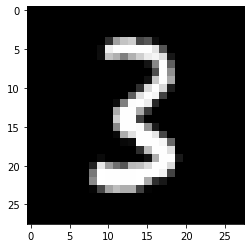

In [62]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [63]:
def fit():
  for epoch in range(epochs):
    for xb, yb in train_dl:
      pred = model(xb)
      loss = loss_func(pred, yb)
      loss.backward()
      opt.step()
      opt.zero_grad()

In [65]:
#In loop we are currently going through data in the same order
#Instead we need to shuffle it around and sample randomly

class Sampler():
  def __init__(self, ds, bs, shuffle=False):
    self.n, self.bs, self.shuffle = len(ds), bs, shuffle

  def __iter__(self):
    self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
    for i in range(0, self.n, self.bs) : yield self.idxs[i:i+self.bs]

In [66]:
small_ds = Dataset(*train_ds[:10])

In [68]:
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [69]:
s = Sampler(small_ds, 3, True)
[o for o in s]

[tensor([2, 0, 3]), tensor([8, 7, 4]), tensor([6, 1, 5]), tensor([9])]